## ***Data Science Engineering Methods***
## ***Assignment 3 – Model Interpretability***


The focus of the previous notebooks was to conduct a comprehensive analysis of the "Avocado Prices" dataset. To accomplish this, I started with data preprocessing tasks such as data cleaning, handling missing values, and encoding categorical variables including exploratory data analysis to identify patterns, trends, and relationships within the dataset.

In this Notebook, I have analyzed the models using Linear Regression, Random Forest Regressor, and Auto ML to find the best model and interpret them. Within this notebook, I have used various methods and techniques to understand the differences between the different models generated. I have used SHAP values and compared them with the other model interpretability methods.

#**About the Dataset**

The data represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the data reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the data reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this data.

**Columns in our Dataset**

1. index
2. Date: The date of the observation
3. AveragePrice: The average price of a single avocado
4. Total Volume: Total number of avocados sold
5. 4046: Total number of avocados with PLU 4046 sold
6. 4225: Total number of avocados with PLU 4225 sold
7. 4770: Total number of avocados with PLU 4770 sold
8. Total Bags
9. Small Bags
10. Large Bags
11. XLarge Bags
12. type: conventional or organic
13. year: The year
14. region: The city or region of the observation

**I will start by installing the necessary packages.**

In [2]:
!pip install xgboost

In [3]:
# for outlier preprocessing
!pip install datasist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.9 MB/s eta 0:00:00


In [4]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import shap
from sklearn.model_selection import  train_test_split

In [6]:
#reading the dataset
import pandas as pd
pandas_df = pd.read_csv('https://raw.githubusercontent.com/Pritika-24/Model-Interpretability/main/avocado.csv')

We will be using a Kaggle dataset on **Avocado Prices** which has **11 Numerical columns** and **3 Categorical columns**. The dataset provides information about Avocado Prices with the help of variables such as total volume, total avocados sold with different PLU's, etc.

Hence our predictor variable here is the **"Total Volume"** column.

In [7]:
#exploring the dataset columns
pandas_df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [8]:
#dropping unnecessary columns
pandas_df = pandas_df.drop(columns=['Unnamed: 0'])

In [9]:
#dropping unnecessary columns
pandas_df = pandas_df.drop(columns=['Date'])

In [10]:
#exploring the dataset columns
pandas_df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


**Checking for null values.**

In [11]:
#checking if the any data is missing
pandas_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

No data is missing from any of the columns

###**Check the number of outliers**

In [12]:
from datasist.structdata import detect_outliers


numeric_columns = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'XLarge Bags', 'year']
index = detect_outliers(pandas_df, 0, numeric_columns)
len(index)

6306

###**Delete outliers and imputate using median**

In [13]:
for col in pandas_df[['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'XLarge Bags', 'year']]:
    outliers_indices = detect_outliers(pandas_df, 0, [col])
    col_median = pandas_df[col].median()
    pandas_df[col].iloc[outliers_indices] = col_median


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

###**Check the boxlpot after processing (no outliers anymore)**

In [14]:
#Confirming that the dataset is not empty:

print(pandas_df.head())

   AveragePrice  Total Volume     4046       4225    4770  Total Bags  \
0          1.33      64236.62  1036.74   54454.85   48.16     8696.87   
1          1.35      54876.98   674.28   44638.81   58.33     9505.56   
2          0.93     118220.22   794.70  109149.67  130.50     8145.35   
3          1.08      78992.15  1132.00   71976.41   72.58     5811.16   
4          1.28      51039.60   941.48   43838.39   75.78     6183.95   

   Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8603.62       93.25          0.0  conventional  2015  Albany  
1     9408.07       97.49          0.0  conventional  2015  Albany  
2     8042.21      103.14          0.0  conventional  2015  Albany  
3     5677.40      133.76          0.0  conventional  2015  Albany  
4     5986.26      197.69          0.0  conventional  2015  Albany  


In [15]:
#Ensuring that the dataset contains numeric data:

print(pandas_df.dtypes)

AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object


In [16]:
#If there are non-numeric columns, filtering out only the numeric data using DataFrame select_dtypes method:

numeric_df = pandas_df.select_dtypes(include=[np.number])

In [17]:
numeric_df = numeric_df.dropna()

In [18]:
%matplotlib inline

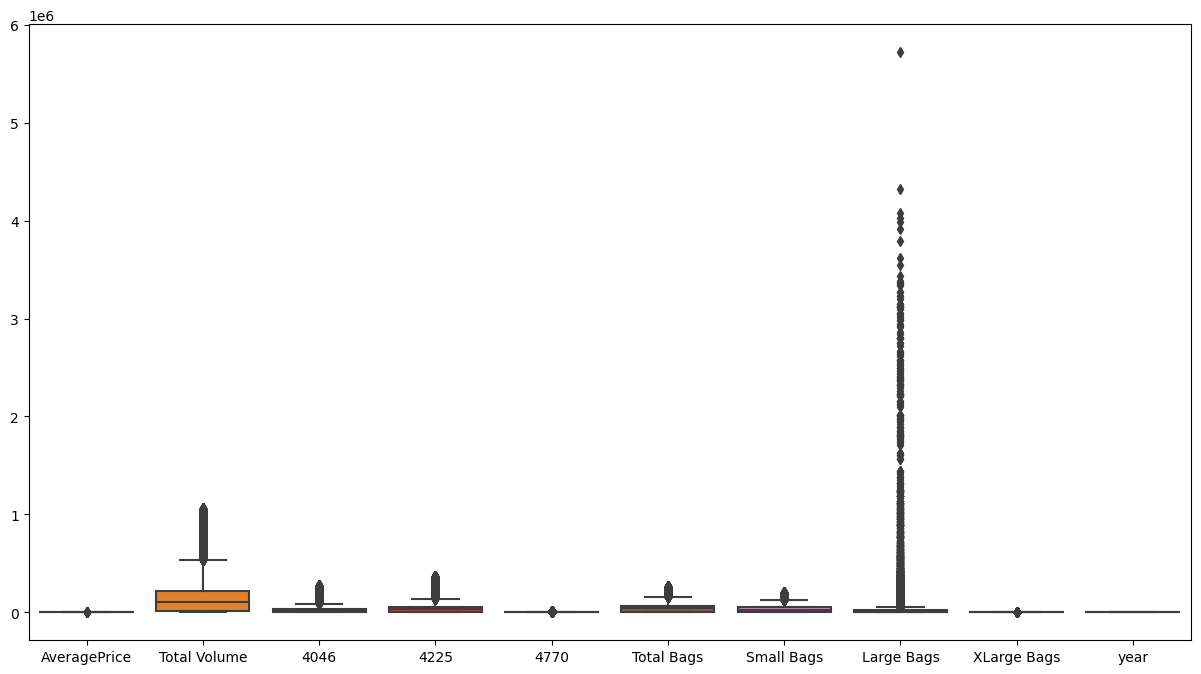

In [19]:
plt.figure(figsize=[15,8])
sns.boxplot(data=numeric_df)
plt.show()

###**For further analysis, I will use the Linear Regression, Random Forest Regressor, and AutoML for generating models and run SHAP analysis on those models, for a better visualization.**

###**1.Linear Regression Model**

In [20]:
X = pandas_df[ ['AveragePrice', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'XLarge Bags', 'year']]

y = pandas_df['Total Volume']

#Spliting data into Training 90%, Test set 10%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Make predictions using the testing set
y_pred = model.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 21401229538.46
Coefficient of determination: 0.62
R^2 score on test set = 0.6156771791804767


In [23]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Total Volume   R-squared (uncentered):                   0.758
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              6414.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                        0.00
Time:                        01:20:59   Log-Likelihood:                     -2.1762e+05
No. Observations:               16424   AIC:                                  4.353e+05
Df Residuals:                   16416   BIC:                                  4.353e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
AveragePrice  -3.13e+04   3213.457     -9.741      0.000   -3.76e+04    -2.5e+04
4046             0.8939      0.022     39.994      0.000       0.850       0.938
4225             0.7124      0.017     42.357      0.000       0.679       0.745
4770             2.2822      0.371      6.147      0.000       1.554       3.010
Total Bags       0.9947      0.037     26.865      0.000       0.922       1.067
Small Bags       1.3404      0.049     27.588      0.000       1.245       1.436
XLarge Bags    157.8184     26.527      5.949      0.000     105.822     209.815
year            24.1299      2.586      9.330      0.000      19.061      29.199
==============================================================================
Omnibus:                     7995.800   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69935.097
Skew:                           2.159   Prob(JB):                         0.00
Kurtosis:                      12.140   Cond. No.                     3.70e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All the features have a p-value of 0.000,  and hence all of them are significant. The coefficient of Average Price is negative which means it has a negative relationship with Total Volume, and all other coefficients are positive so their relationship with Total Volume is positive.

###**SHAP**

In [24]:
shap.initjs()

In [25]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 1826it [00:33, 51.73it/s]                          


From the plot below, it is known that **"Small Bags"** is the most effective feature in the Linear Regression model, followed by **"Total Bags"**

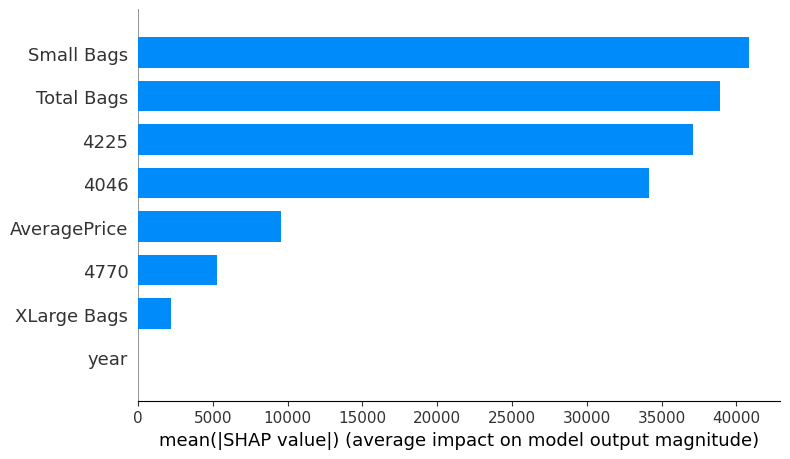

In [26]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar")

**From the SHAP summary plot below, the following inferences can be made:**

1. 'Small Bags' appear to be the feature with the most substantial impact on the model's output, contributing to an increase in the predicted value when the feature value is high.

2. 'Total Bags' and the feature represented by '4225' also have a significant influence, behaving similarly to 'Small Bags' in terms of driving the model's predictions upwards.

3. 'AveragePrice' shows a mix of positive and negative effects on the prediction. When its value is lower than average, it tends to increase the predicted outcome, whereas higher values decrease the predicted outcome.

4. 'XLarge Bags' and 'year' seem to have a lesser and more uniform impact, with 'year' having a negligible effect compared to other features, suggesting it may be less critical in this model's predictions.

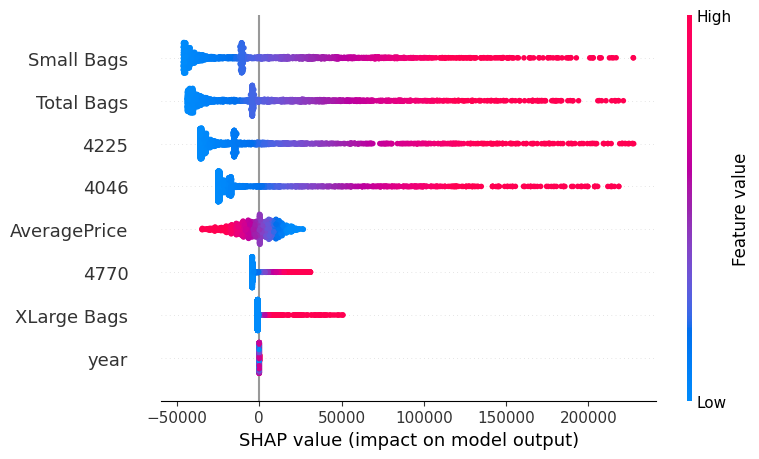

In [27]:
shap.summary_plot(shap_values, X_test)

###**Partial Dependence Plots**

**The below illustrations are partial dependence plots, showing the impact of each feature on the model.**

Given the numerous features in our model, creating a partial dependence plot for each one is a complex task. Furthermore, comparing all features simultaneously is challenging. The SHAP method is more favorable and I will not include PDP examples for the subsequent two models.

In [28]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            model.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature,
            model.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

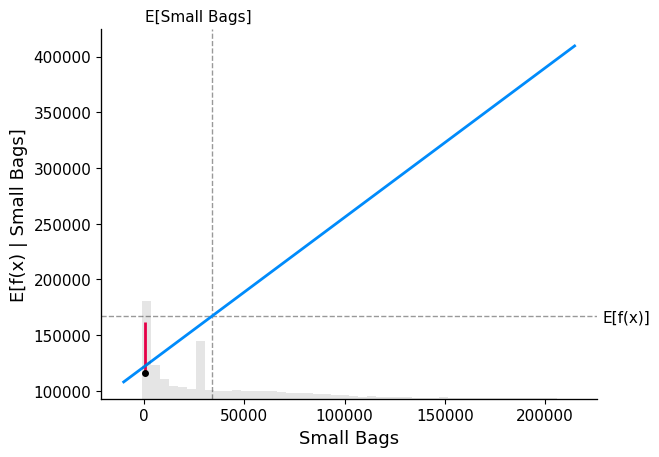

In [29]:
partial_dependence_plot('Small Bags', 0)

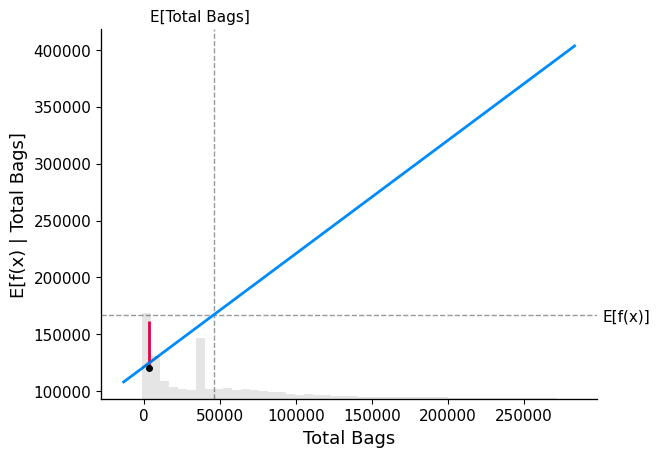

In [30]:
partial_dependence_plot('Total Bags', 0)

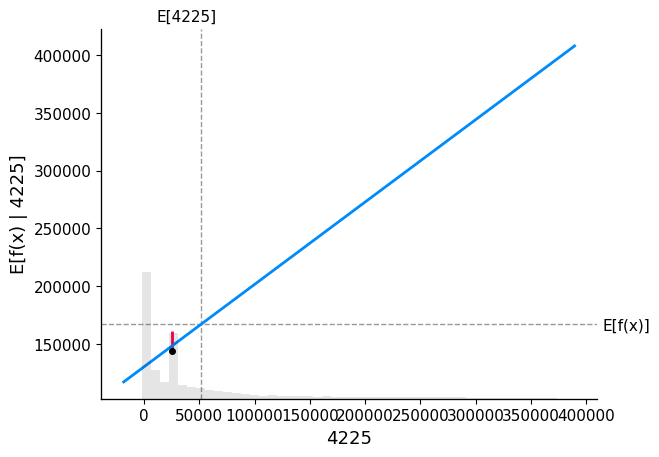

In [31]:
partial_dependence_plot('4225', 0)

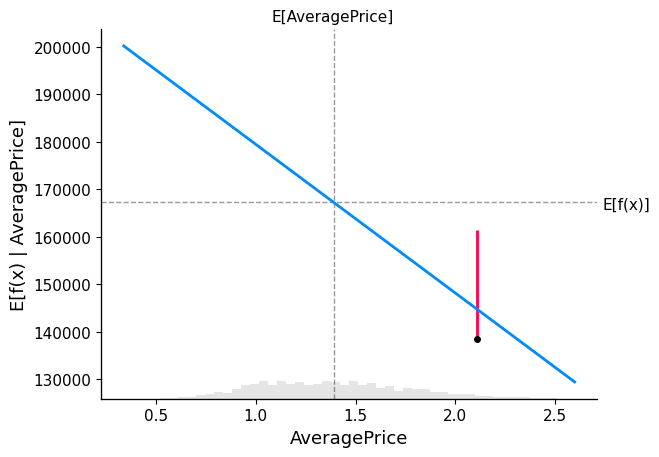

In [32]:
partial_dependence_plot('AveragePrice', 0)

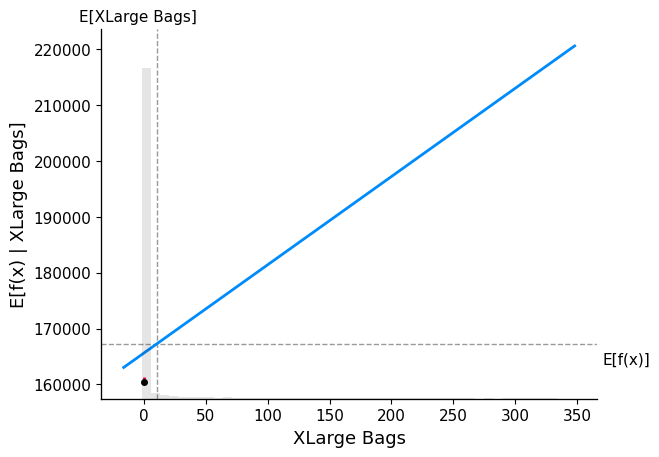

In [33]:
partial_dependence_plot('XLarge Bags', 0)

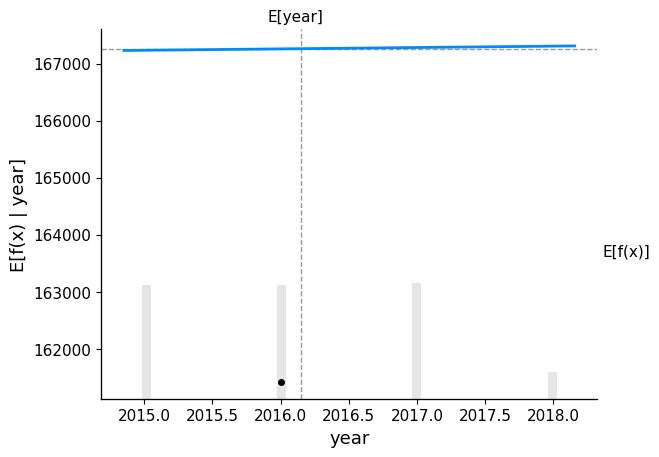

In [34]:
partial_dependence_plot('year', 0)

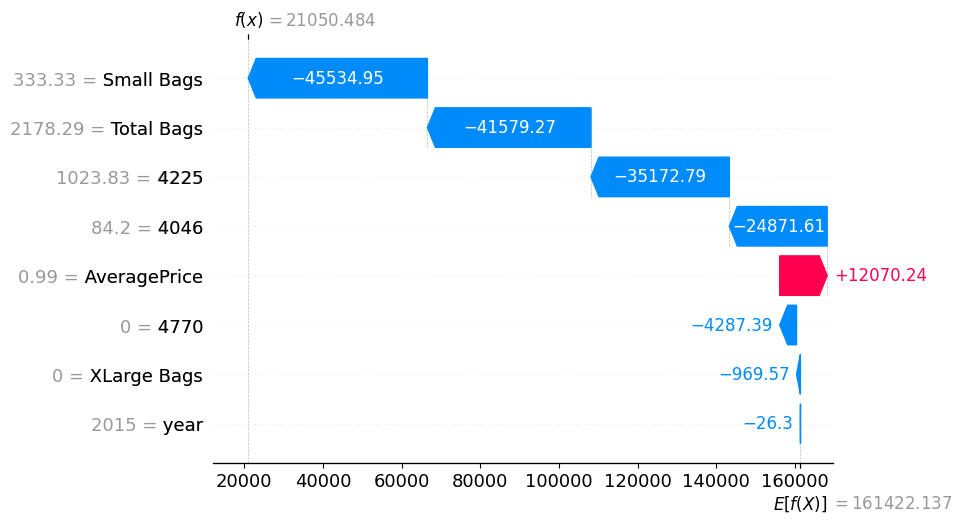

In [43]:
idx = 18
shap.plots.waterfall(shap_values[idx], max_display=14)

The red color means a higher value of a feature. Blue means the lower value of a feature. The base value here is given as 161422.137, which is the average predicted value of the Total Volume of Avocados sold.

"Small Bags", "Total Bags", "4225", "4046" impact the model predictability negatively or the feature/variable which is "Total Volume" significantly. Whereas the "Average Price" has a positive impact in the prediction of "Total Volume".

**"Small Bags", "Total Bags", "4225", "4046", "4770", "XLarge Bags", and "year"** are responsible for the **increase in the Total Volume** of Avocados sold, while the **other features**, **"Average Price"** is responsible for **decreasing in the Total Volume** of Avocados sold.

###**2. Random Forest Model**

In [44]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [45]:
# Make predictions using the testing set
y_pred = model.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 5681494825.94
Coefficient of determination: 0.90
R^2 score on test set = 0.8979718378304609


**We will visualize the features that are important from their coefficients.**

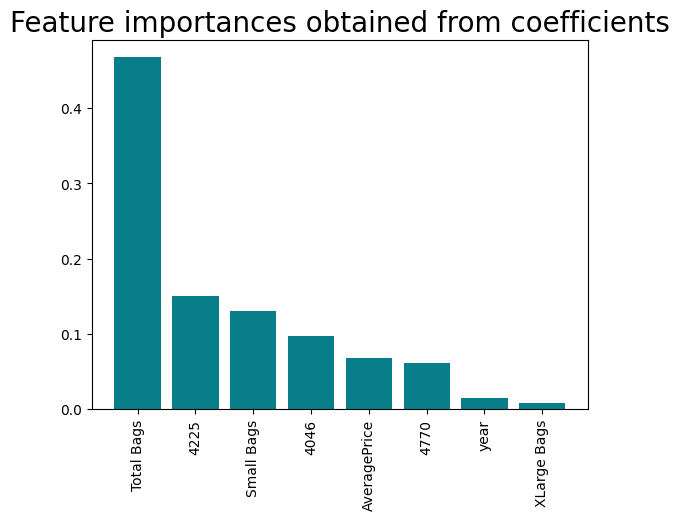

In [46]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

**Here we notice that, "Total Bags" has been the most important feature followed by "4225".**

###**SHAP Analysis for the Randomforest Regressor Model**

In [47]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 1826it [06:57,  4.26it/s]


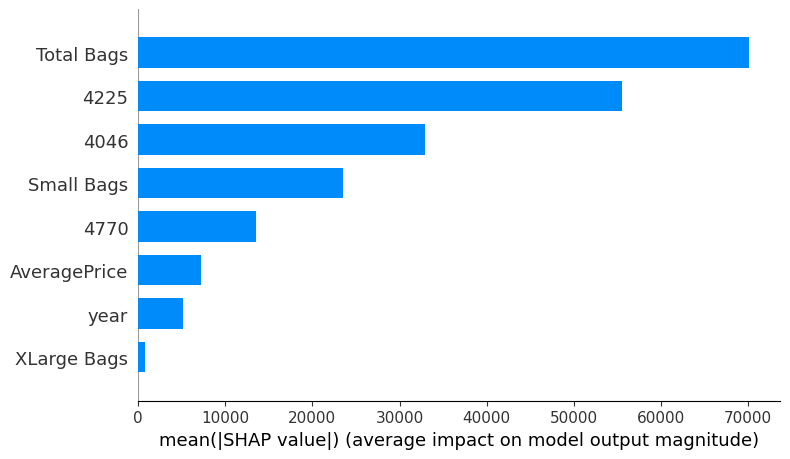

In [48]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar")

From the plot above, it is known that **"Total Bags"** is the most effective feature in the Random Forest regressor model, followed by **"4225".**

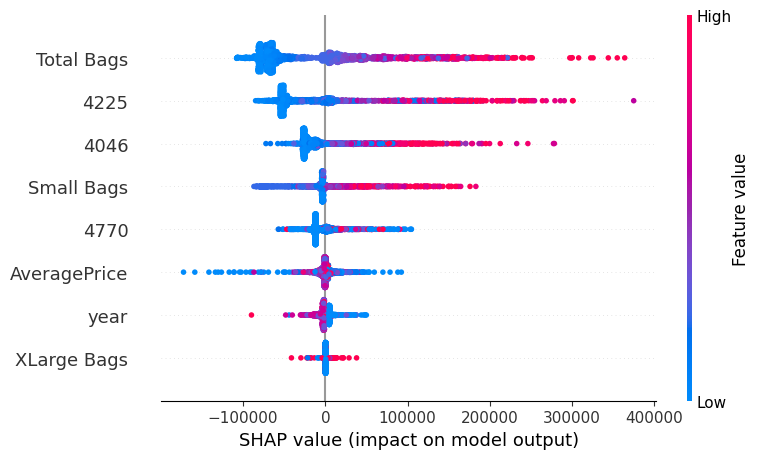

In [49]:
shap.summary_plot(shap_values, X_test)

1. Total Bags' has the most substantial influence on the model's predictions. A
mix of low and high values of 'Total Bags' spreads out on both sides of the zero line, indicating that it can both increase and decrease the predicted outcome depending on the specific value.

2. 'Small Bags' also has a significant impact, primarily contributing to an increase in the predicted value, as indicated by the dots predominantly positioned to the right of the zero line.

3. '4225', '4046', and '4770' appear to be product size codes and show varying degrees of influence. The cluster of dots for these features suggests a mix of positive and negative impacts on the model's predictions.

4. 'AveragePrice' and 'Year' have a smaller spread of SHAP values, suggesting a more moderate influence on the prediction outcomes. The clustering near the zero line indicates their effect is not as pronounced as 'Total Bags' or 'Small Bags'.

5. 'XLarge Bags' appears to have the least impact on the model's output, with SHAP values clustered close to the zero line and a narrow spread, suggesting that changes in 'XLarge Bags' values do not significantly alter the prediction.

The color gradient from blue to pink represents the low to high feature values, respectively, giving insight into how the magnitude of each feature's value influences the model's prediction.

The base value in the below waterfall plot is given as 170232.545, which is the average predicted value of the Total Volume.

"Total Bags" decreases the expectancy of the predicted feature/variable significantly, whereas, "year" increases the Life expectancy rate the most out of all the other variables.

**"Total Bags", "4225", "4046", "4770", and "Small Bags"** are responsible for the **decrease in Total Volume**, while the other features like **"year", "Average Price", and "XLarge Bags"** are responsible for **increase in Total Volume.**

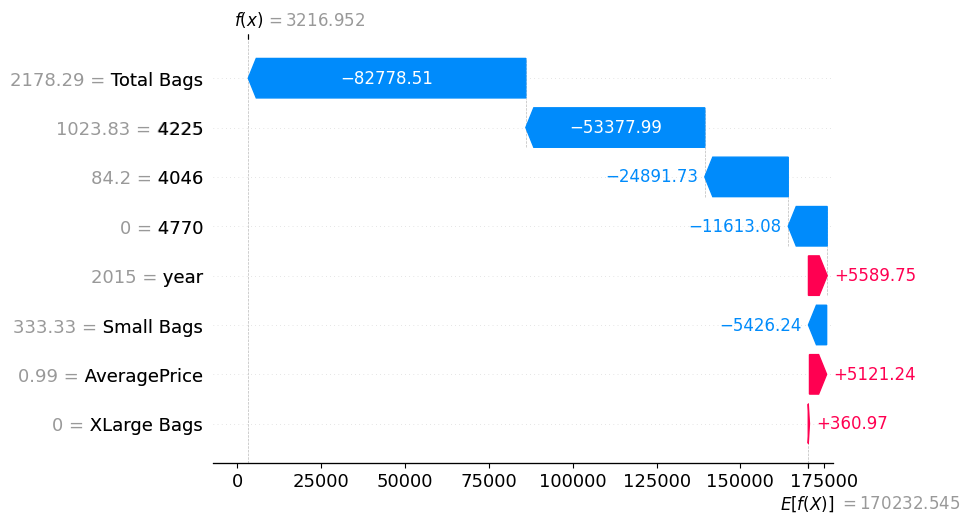

In [50]:
#Waterfall Plot
idx = 18
shap.plots.waterfall(shap_values[idx], max_display=14)

###**3.AutoML**

In [51]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.2-py2.py3-none-any.whl size=265363806 sha256=ad68441f12c7a515042b41bbf81fd0c85376bbe18b1af967bfe61550f9b62df5
  Stored in directory: /root/.cache/pip/wheels/e9/ea/ab/889709967692e30c57c46137edd2cae6b2768bb65ec7cb8aa5
Successfully built h2o


In [52]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqcn7frwk
  JVM stdout: /tmp/tmpqcn7frwk/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqcn7frwk/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_aq7bgh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [53]:
pandas_df = h2o.H2OFrame(pandas_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [54]:
pandas_df.head()

AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
1.33,64236.6,1036.74,54454.8,48.16,8696.87,8603.62,93.25,0,conventional,2015,Albany
1.35,54877,674.28,44638.8,58.33,9505.56,9408.07,97.49,0,conventional,2015,Albany
0.93,118220,794.7,109150,130.5,8145.35,8042.21,103.14,0,conventional,2015,Albany
1.08,78992.1,1132,71976.4,72.58,5811.16,5677.4,133.76,0,conventional,2015,Albany
1.28,51039.6,941.48,43838.4,75.78,6183.95,5986.26,197.69,0,conventional,2015,Albany
1.26,55979.8,1184.27,48068,43.61,6683.91,6556.47,127.44,0,conventional,2015,Albany
0.99,83453.8,1368.92,73672.7,93.26,8318.86,8196.81,122.05,0,conventional,2015,Albany
0.98,109428,703.75,101815,80,6829.22,6266.85,562.37,0,conventional,2015,Albany
1.02,99811.4,1022.15,87315.6,85.34,11388.4,11104.5,283.83,0,conventional,2015,Albany
1.07,74338.8,842.4,64757.4,113,8625.92,8061.47,564.45,0,conventional,2015,Albany


In [55]:
train, test = pandas_df.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [56]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_pandas_df = train.rbind(test)
drift_pandas_df["is_train"] = drift_pandas_df["is_train"].asfactor()

In [57]:
drift_pandas_df["is_train"].table()

is_train,Count
0,4509
1,13740


In [58]:
x = list(set(train.col_names) - set(["Total Volume"]))

In [59]:
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="Total Volume", training_frame=train)

AutoML progress: |
03:05:46.945: _train param, Dropping bad and constant columns: [is_train]

██
03:06:41.208: _train param, Dropping bad and constant columns: [is_train]


03:06:44.132: _train param, Dropping bad and constant columns: [is_train]

████
03:07:26.588: _train param, Dropping bad and constant columns: [is_train]

█
03:07:40.367: _train param, Dropping bad and constant columns: [is_train]

██
03:08:14.275: _train param, Dropping bad and constant columns: [is_train]

█
03:08:30.809: _train param, Dropping bad and constant columns: [is_train]

█
03:08:41.576: _train param, Dropping bad and constant columns: [is_train]

█
03:08:53.640: _train param, Dropping bad and constant columns: [is_train]

█
03:09:10.963: _train param, Dropping bad and constant columns: [is_train]

███
03:10:21.754: _train param, Dropping unused columns: [is_train]

█
03:10:26.858: _train param, Dropping unused columns: [is_train]

██████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20231204_30546


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    41                 41                          3.31882e+06            20           20           20            5367          6791          6173.34

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 6252836812.539495
RMSE: 79074.88104663513
MAE: 21822.705910209974
RMSLE: 0.22778465522289593
Mean Residual Deviance: 6252836812.539495

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 5771801456.162641
RMSE: 75972.37297967362
MAE: 20688.44273266064
RMSLE: 0.22015680225695985
Mean Residual Deviance: 5771801456.162641

Cross-Validation Metrics Summary: 
                        mean        sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     20688.4     323.333     20987.2       20475.3       20338.8       21071.8       20569
mean_residual_deviance  5.7718e+09  4.9177e+08  5.17204e+09   6.16313e+09   5.96171e+09   6.23837e+09   5.32375e+09
mse                     5.7718e+09  4.9177e+08  5.17204e+09   6.16313e+09   5.96171e+09   6.23837e+09   5.32375e+09
r2                      0.88678     0.00763261  0.898106      0.880354      0.883642      0.880798      0.891002
residual_deviance       5.7718e+09  4.9177e+08  5.17204e+09   6.16313e+09   5.96171e+09   6.23837e+09   5.32375e+09
rmse                    75916.4     3259.65     71916.9       78505.6       77212.1       78983.4       72964.1
rmsle                   0.220078    0.00657172  0.223226      0.221789      0.209974      0.218008      0.227395

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-12-04 03:08:07  27.417 sec  0                  nan              nan             nan
    2023-12-04 03:08:08  28.198 sec  5                  100969           27217.9         1.01948e+10
    2023-12-04 03:08:09  28.812 sec  10                 89458.2          24507.4         8.00277e+09
    2023-12-04 03:08:09  29.366 sec  15                 84599.8          23255.7         7.15713e+09
    2023-12-04 03:08:10  29.900 sec  20                 81934.2          22592.8         6.71322e+09
    2023-12-04 03:08:11  30.716 sec  25                 81012.6          22337.8         6.56304e+09
    2023-12-04 03:08:12  31.656 sec  30                 80145.9          22139.4         6.42337e+09
    2023-12-04 03:08:12  32.551 sec  35                 79585.9          21907           6.33391e+09
    2023-12-04 03:08:13  33.439 sec  40                 79357.8          21866.2         6.29766e+09
    2023-12-04 03:08:14  33.827 sec  41                 79074.9          21822.7         6.25284e+09

Variable Importances: 
variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ------------
Small Bags    4.2777e+15             1                    0.196977
region        4.25306e+15            0.99424              0.195843
Total Bags    3.589e+15              0.839004             0.165265
4225          3.47163e+15            0.811565             0.15986
4046          1.97796e+15            0.462388             0.0910798
4770          1.45183e+15            0.339395             0.0668531
type          1.04631e+15            0.244597             0.0481799
AveragePrice  7.43463e+14            0.1738           

In [60]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DRF_1_AutoML_1_20231204_30546,20688.4,75972.4,5.7718e+09,0.220157,5.7718e+09
StackedEnsemble_BestOfFamily_1_AutoML_1_20231204_30546,21139.8,74273.9,5.51661e+09,nan,5.51661e+09
StackedEnsemble_AllModels_1_AutoML_1_20231204_30546,21226.4,74197.8,5.50531e+09,nan,5.50531e+09
GBM_4_AutoML_1_20231204_30546,21495.7,74871.9,5.6058e+09,nan,5.6058e+09
GBM_3_AutoML_1_20231204_30546,23010.3,76407.7,5.83813e+09,nan,5.83813e+09
GBM_2_AutoML_1_20231204_30546,23728.6,77288,5.97344e+09,nan,5.97344e+09
XRT_1_AutoML_1_20231204_30546,24577.3,78556.6,6.17113e+09,0.233757,6.17113e+09
GBM_1_AutoML_1_20231204_30546,26210.1,79179.6,6.26941e+09,nan,6.26941e+09
XGBoost_2_AutoML_1_20231204_30546,28857.6,85120.9,7.24557e+09,nan,7.24557e+09
XGBoost_3_AutoML_1_20231204_30546,30209.1,82675.3,6.83521e+09,nan,6.83521e+09


In [61]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 5080241602.342991
RMSE: 71275.81358597733
MAE: 20043.99961126699
RMSLE: 0.2217059653251631
Mean Residual Deviance: 5080241602.342991

In [62]:
# Help function
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class

In [63]:
#Reading dataset

pandas_df = pd.read_csv('https://raw.githubusercontent.com/Pritika-24/Model-Interpretability/main/avocado.csv')

In [64]:
X = pandas_df[ ['AveragePrice', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'XLarge Bags', 'year']]
y = pandas_df['Total Volume']

#Spliting data into Training 90%, Test set 10%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [65]:
feature_names = list(X_train.columns)
h2o_wrapper = H2OProbWrapper(best_model,feature_names)

In [66]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob,X_train[:50])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


In [67]:
shap_values = explainer.shap_values(X_test[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN
Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Test/Validation dataset is missing column 'Large Bags': substituting in a column of NaN
Test/Validation dataset is missing column 'type': substituting in a column of NaN
Test/Validation dataset is missing column 'region': substituting in a column of NaN


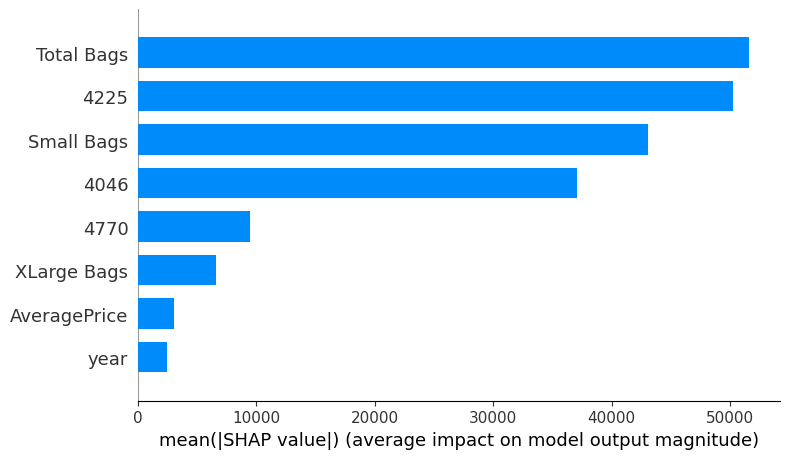

In [68]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

1. From the two plots above, we can know that Total Bags is the most effective feature in Random Forest model, when it's value is larger than average, it drives the prediction to the right.

2. Here the data points are sparsely distanced with a more or less similar trend to the previous two models.

3. 4225, Small bags, 4046, 4770 and XLarge Bags works similar to Total Bags, however, Average Price and year work the opposite.

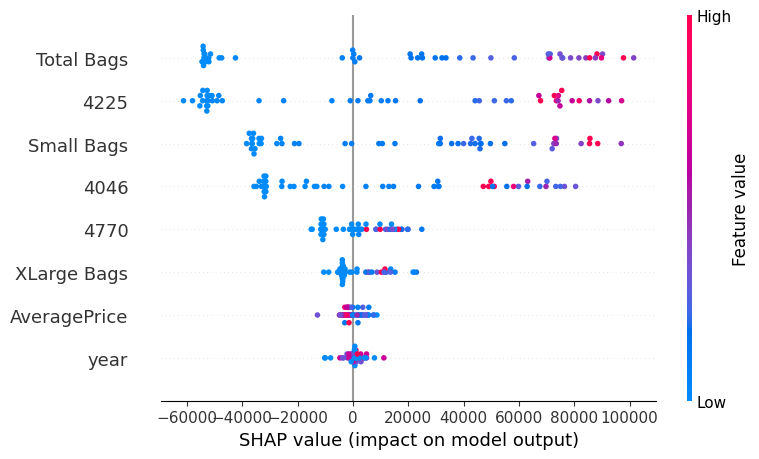

In [69]:
shap.summary_plot(shap_values, X_test[:50])

#**Conclusion**

Different models were analyzed using the SHAP values. The SHAP values were interpreted for Linear Regression, Random Forest regressor, and AutoML models.

#**References**

- SHAP documentation: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/, https://shap.readthedocs.io/en/latest/

- Linear Regression: https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.ibm.com%2Ftopics%2Flinear-regression%23%3A%7E%3Atext%3DResources-%2CWhat%2520is%2520linear%2520regression%253F%2Cis%2520called%2520the%2520independent%2520variable


- Github: https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb

- ChatGPT - https://chat.openai.com/chat

70% code is written by me with the other 30% referenced and modified from various sources such as stackoverflow geeksforgeeks and ChatGPT



###**License**

Copyright 2023 Pritika-24

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.